In [28]:
import pandas as pd
import os

#  1. 회원정보 파일 경로 리스트
member_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201807_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

#  2. 마케팅정보 파일 경로 리스트
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201807_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201808_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201809_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201810_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201811_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201812_train_마케팅정보.parquet"
]

# 3. 기준년월 컬럼 추가 및 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

#  3. 데이터 로딩
member_df = load_and_merge_parquet(member_file_paths)
marketing_df = load_and_merge_parquet(marketing_file_paths)

#  4. segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in member_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)
segment_col = segment_col_candidates[-1]  # 예: 'Segment'

if member_df[segment_col].dtype == 'object':
    member_df[segment_col] = member_df[segment_col].astype('category').cat.codes

#  5. 병합 ('ID', '기준년월' 기준)
merged_df = pd.merge(member_df, marketing_df, on=['ID', '기준년월'], how='inner')

# 6. 범주형 segment → 숫자형으로 변환
if merged_df[segment_col].dtype == 'object':
    merged_df[segment_col] = merged_df[segment_col].astype('category').cat.codes

# 7.결측치 제거 및 std=0 컬럼 제거
clean_df = merged_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]

#  8. numeric_cols를 clean_df 기준으로 정리
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]


# 9. 상관계수 계산
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in numeric_cols
}

# 10. 정리 및 출력
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['상관계수'])
corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 인덱스를 컬럼으로 변환해 가독성 향상
corr_df.reset_index(inplace=True)
corr_df.rename(columns={'index': '컬럼명'}, inplace=True)

#  보기 좋게 스타일링
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

#  주피터에서 예쁘게 출력
display(styled)


사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수
0,이용금액_R3M_신용체크,-0.623582
1,이용금액_R3M_신용,-0.589792
2,_1순위카드이용금액,-0.574799
3,_2순위카드이용금액,-0.386804
4,이용카드수_신용체크,-0.381942
5,이용카드수_신용,-0.359620
6,_2순위카드이용건수,-0.358716
7,_1순위카드이용건수,-0.356594
8,이용가능카드수_신용체크,-0.345848
9,이용가능카드수_신용,-0.345561


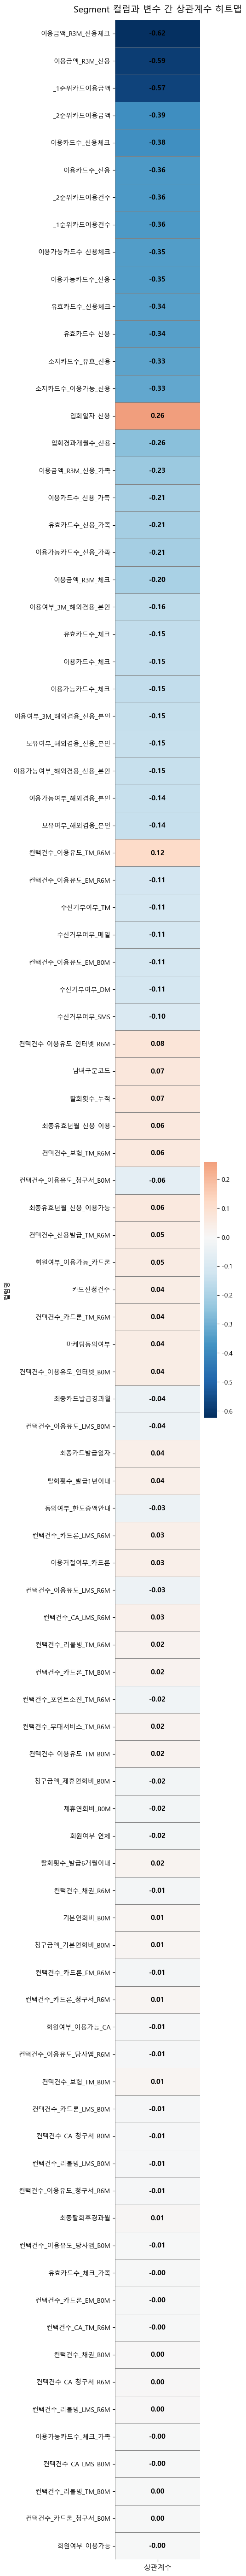

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 세로 히트맵용 데이터
heatmap_df = corr_df.set_index('컬럼명')

# 시각화
fig, ax = plt.subplots(figsize=(5, max(12, len(corr_df) * 0.6)), constrained_layout=True)

sns.heatmap(
    heatmap_df,
    annot=True, fmt=".2f", cmap='RdBu_r', center=0,
    annot_kws={"size": 11, "color": "black", "weight": "bold"},  # ✅ 숫자 크게, 진하게, 검정색
    linewidths=0.7, linecolor='gray',
    cbar=True,
    ax=ax
)

ax.set_title("Segment 컬럼과 변수 간 상관계수 히트맵", fontsize=14, pad=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.show()


In [35]:
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
print("선별된 변수 수:", len(corr_filtered))
display(corr_filtered)

선별된 변수 수: 14


,컬럼명,상관계수
0,이용금액_R3M_신용체크,-0.623582
1,이용금액_R3M_신용,-0.589792
2,_1순위카드이용금액,-0.574799
3,_2순위카드이용금액,-0.386804
4,이용카드수_신용체크,-0.381942
5,이용카드수_신용,-0.359620
6,_2순위카드이용건수,-0.358716
7,_1순위카드이용건수,-0.356594
8,이용가능카드수_신용체크,-0.345848
9,이용가능카드수_신용,-0.345561


In [37]:
# 1. 상관계수 기준으로 변수 필터링
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
selected_cols = corr_filtered['컬럼명'].tolist()

# 2. 선택된 컬럼 + segment 포함된 데이터프레임 만들기
selected_df = clean_df[selected_cols + [segment_col]]

# 3. 저장 경로 설정
import os
output_dir = "C:/Users/HR/Desktop/workspace/파이널프로젝트"
output_path = os.path.join(output_dir, "segment_마케팅정보_상관계수_0.3이상.csv")

# 4. 저장
selected_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"저장 완료: {output_path}")


저장 완료: C:/Users/HR/Desktop/workspace/파이널프로젝트\segment_마케팅정보_상관계수_0.3이상.csv


In [1]:
import pandas as pd
import os

# 1. 회원정보 파일 경로 리스트
member_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201807_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201808_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201809_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201810_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201811_train_회원정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/1.회원정보/201812_train_회원정보.parquet"
]

# 2. 마케팅정보 파일 경로 리스트
marketing_file_paths = [
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201807_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201808_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201809_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201810_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201811_train_마케팅정보.parquet",
    "C:/Users/HR/Desktop/workspace/파이널프로젝트/open/train/7.마케팅정보/201812_train_마케팅정보.parquet"
]

# 3. 기준년월 컬럼 추가 및 병합 함수
def load_and_merge_parquet(file_paths):
    df_list = []
    for path in file_paths:
        df = pd.read_parquet(path)
        기준년월 = os.path.basename(path).split('_')[0]
        df['기준년월'] = 기준년월
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

# 4. 데이터 로딩
member_df = load_and_merge_parquet(member_file_paths)
marketing_df = load_and_merge_parquet(marketing_file_paths)

# 5. Segment 컬럼 자동 탐색 및 숫자형 변환
segment_col_candidates = [col for col in member_df.columns if 'segment' in col.lower()]
print("사용 가능한 segment 컬럼 후보:", segment_col_candidates)
segment_col = segment_col_candidates[-1]

if member_df[segment_col].dtype == 'object':
    member_df[segment_col] = member_df[segment_col].astype('category').cat.codes

# 6. 두 DataFrame을 'ID'와 '기준년월' 기준으로 inner join (병합 아님, 동기화)
target_cols = ['ID', '기준년월', segment_col]
member_target = member_df[target_cols]
combined_df = pd.merge(member_target, marketing_df, on=['ID', '기준년월'], how='inner')

# 7. 분석 대상 numeric 컬럼만 선택
numeric_cols = [col for col in combined_df.select_dtypes(include=['int64', 'float64']).columns if col != segment_col]

# 8. 결측치 제거 및 std=0 컬럼 제거
clean_df = combined_df[numeric_cols + [segment_col]].dropna()
clean_df = clean_df.loc[:, clean_df.std() != 0]
numeric_cols = [col for col in numeric_cols if col in clean_df.columns]

# 9. 결측치 수 계산
missing_dict = {
    col: combined_df[col].isnull().sum()
    for col in numeric_cols
}

# 10. 이상치 수 계산 (IQR 기준)
outlier_dict = {}
for col in numeric_cols:
    Q1 = combined_df[col].quantile(0.25)
    Q3 = combined_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((combined_df[col] < lower_bound) | (combined_df[col] > upper_bound)).sum()
    outlier_dict[col] = outliers

# 11. 상관계수 계산
corr_dict = {
    col: clean_df[segment_col].corr(clean_df[col])
    for col in numeric_cols
}

# 12. 결과 정리
corr_df = pd.DataFrame({
    '컬럼명': list(corr_dict.keys()),
    '상관계수': list(corr_dict.values()),
    '결측치 수': [missing_dict[col] for col in corr_dict.keys()],
    '이상치 수': [outlier_dict[col] for col in corr_dict.keys()]
})

corr_df = corr_df.sort_values(by='상관계수', key=abs, ascending=False)

# 13. 스타일링 출력
from IPython.display import display
styled = corr_df.style.background_gradient(cmap='coolwarm', subset=['상관계수']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled)




사용 가능한 segment 컬럼 후보: ['Segment']


,컬럼명,상관계수,결측치 수,이상치 수
20,컨택건수_이용유도_TM_R6M,0.149037,0,103328
30,컨택건수_이용유도_EM_R6M,-0.133304,0,399903
11,컨택건수_이용유도_EM_B0M,-0.127584,0,349290
14,컨택건수_이용유도_청구서_B0M,-0.081478,0,0
2,컨택건수_이용유도_TM_B0M,0.069907,0,64948
34,컨택건수_이용유도_인터넷_R6M,0.062556,0,0
21,컨택건수_신용발급_TM_R6M,0.043946,0,24103
9,컨택건수_이용유도_LMS_B0M,-0.041246,0,0
24,컨택건수_보험_TM_R6M,0.029710,0,148802
23,컨택건수_포인트소진_TM_R6M,-0.029200,0,15619


In [2]:
corr_filtered = corr_df[abs(corr_df['상관계수']) >= 0.3]
print("선별된 변수 수:", len(corr_filtered))
display(corr_filtered)

선별된 변수 수: 0


,컬럼명,상관계수,결측치 수,이상치 수


In [3]:
# 14. CSV로 저장
save_path = "C:/Users/HR/Desktop/workspace/파이널프로젝트/segment_마케팅정보_상관계수_전체.csv"
corr_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"📁 상관계수 결과 저장 완료: {save_path}")

📁 상관계수 결과 저장 완료: C:/Users/HR/Desktop/workspace/파이널프로젝트/segment_마케팅정보_상관계수_전체.csv
